## Задача
Возможность онлайн-бронирования отелей кардинально изменили бронирование и поведение гостей. Значительное количество бронирований аннулируется по той или иной причине. Типичные причины: изменение планов, форс-мажорные обстоятельства и т.д.. Чаще отменяется бронь, если отмена бесплатная или имеет небольшую цену, что совсем не приноссит доход отелю.

Можете ли вы предсказать, выполнит клиент бронирование или отменит его?

## Описание данных

- `Booking_ID` — уникальный номер каждой брони
- `no_of_adults` — количество взрослых
- `no_of_children` — количество детей
- `no_of_weekend_nights` — количество выходных дней, проведенных гостем в отеле (суббота или воскресенье)
- `no_of_week_nights` — количество будних дней, проведенных гостем в отеле(с ппонедельника по пятницу)
- `type_of_meal_plan` — тип питания
- `required_car_parking_space` — требуется ли гостю парковочное место (0 - нет, 1- да)
- `room_type_reserved` — тип номера, заюронированного клиентом. Значения шифруются гостиницей
- `lead_time` — количество дней между датой бронирования и датой прибытия
- `arrival_year` — год прибытия
- `arrival_month` — месяц прибытия
- `arrival_date` — день прибытия (день месяца)
- `market_segment_type` — способ брони
- `repeated_guest` — является ли гость постоянным (0 - нет, 1- является)
- `no_of_previous_cancellations` — количество предыдущих бронирований, которые были отменены клиентом до текущего бронирования
- `no_of_previous_bookings_not_canceled` — количество предыдущих бронирований, не отмененных клиентом до текущего бронирования
- `avg_price_per_room` — средняя цена за сутки бронирования; цены за номера динамичны. (в евро)
- `no_of_special_requests` — количество особых запросов, сделанных клиентом (например, верхний этаж, вид из комнаты и т. д.)
- `booking_status` — было ли бронирование отменено (0 - нет, 1- да)

## План  

**1. Проведение обзора данных**  
   
   1.1 Первичное исследование данных   
   1.2 Предобработка данных   
   1.3 Исследование итоговой таблицы с данными   

**2. Построение модели машинного обучения**  

   2.1 Логистическая регрессия   
   2.2 Метод ближайших соседей   
   2.3 Дерево решений
   2.4 Случайный лес  
   2.5 Градиентный бустинг
   
**3. Общий вывод**   

# 1. Проведение обзора данных

### 1.1 Первичное исследование данных

In [1]:
#Загрузка библиотек и глобальных переменных
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import numpy as np
from random import shuffle
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

#### Пользовательские функции

In [2]:
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)
    
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T) 
    
    
    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')    
    df_object = data_df.select_dtypes(include='object').columns
    
    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())

In [3]:
def plot_hist(data, col_column):
    '''
    Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows, 2, figsize=(8, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(14)
    plt.rcParams.update({'font.size': 18})
    
    for i, col in enumerate(col_column):         
        sns.histplot(data[col], kde=True, bins=24, ax = ax[i, 0])                    
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количесвтенных данных", fontsize=22, y=1.01)
    plt.show()

#### Загрузка данных и первичных осмотр

In [4]:
data = pd.read_csv('C:/Users/weeqe/projects/data/Hotel Reservations.csv')

In [5]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ
check_data(data)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
no_of_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
no_of_weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
no_of_week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
required_car_parking_space,36275.0,0.030986,0.173281,0.0,0.0,0.00,0.0,1.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
arrival_year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0,2018.0
arrival_month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0,12.0
arrival_date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
repeated_guest,36275.0,0.025637,0.158053,0.0,0.0,0.00,0.0,1.0



Описание категориальных данных:


,count,unique,top,freq
Booking_ID,36275,36275,INN00001,1
type_of_meal_plan,36275,4,Meal Plan 1,27835
room_type_reserved,36275,7,Room_Type 1,28130
market_segment_type,36275,5,Online,23214
booking_status,36275,2,Not_Canceled,24390



Вывод уникальных значений по каждому категориаьному признаку:
_Booking_ID


INN00001    1
INN24187    1
INN24181    1
INN24182    1
INN24183    1
           ..
INN12086    1
INN12085    1
INN12084    1
INN12083    1
INN36275    1
Name: Booking_ID, Length: 36275, dtype: int64

_type_of_meal_plan


Meal Plan 1     27835
Not Selected     5130
Meal Plan 2      3305
Meal Plan 3         5
Name: type_of_meal_plan, dtype: int64

_room_type_reserved


Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: room_type_reserved, dtype: int64

_market_segment_type


Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: market_segment_type, dtype: int64

_booking_status


Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64

In [6]:
# ГРАФИЧЕСКИЙ АНАЛИЗ количественных данных данных
num_features = data.select_dtypes(exclude=[object]).columns

# Проверка
num_features

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'lead_time',
       'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests'],
      dtype='object')

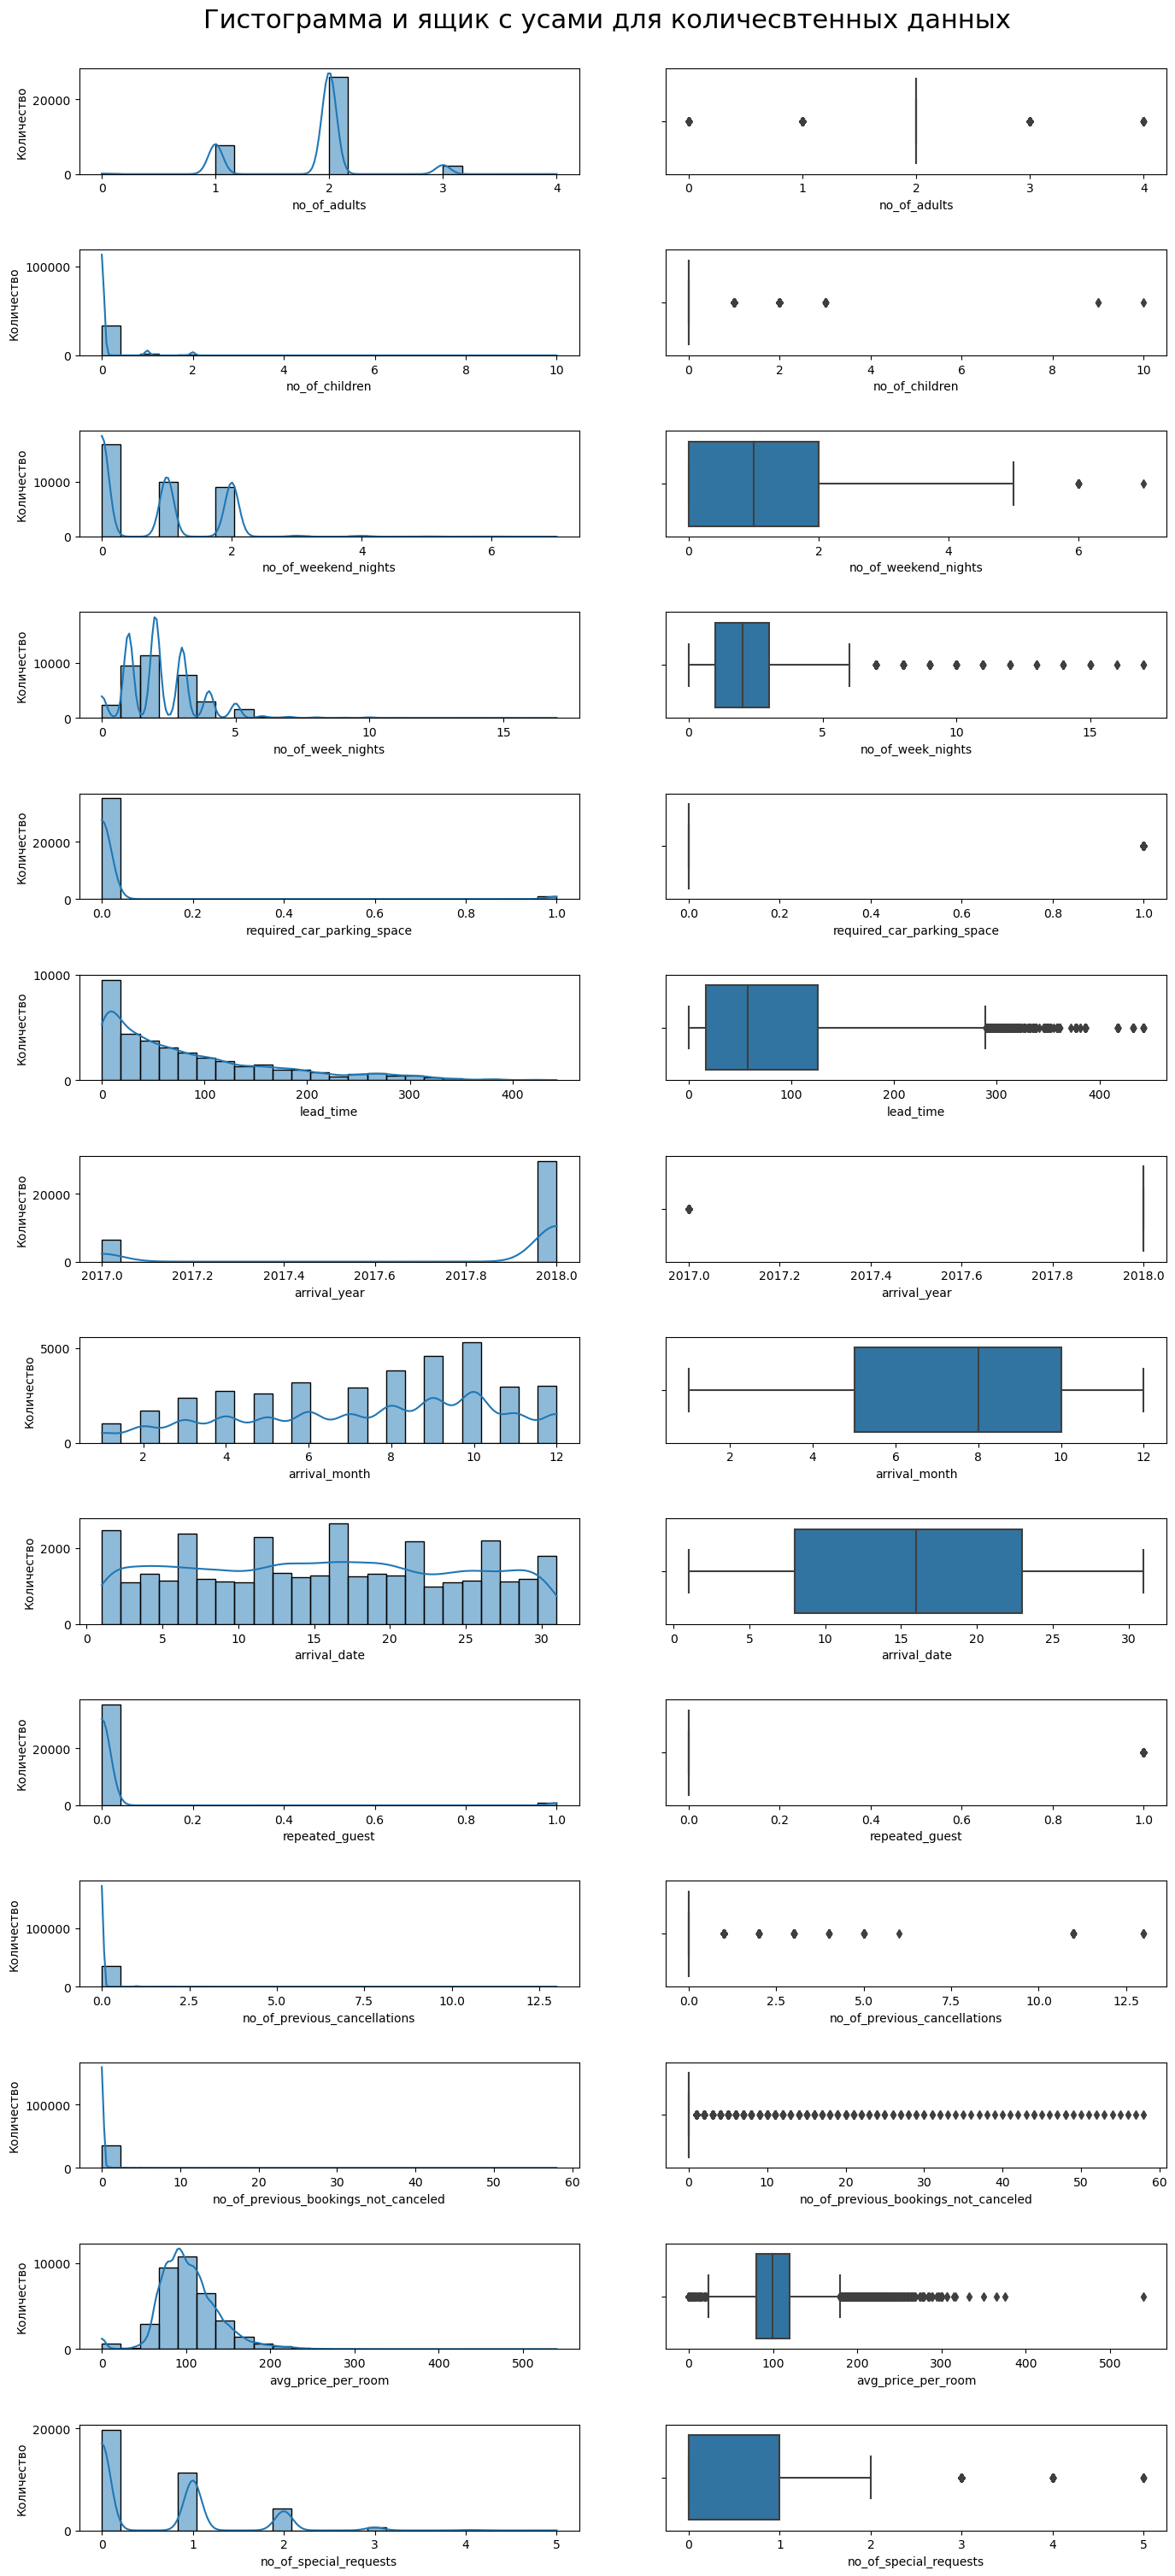

In [7]:
plot_hist(data, num_features)

**Вывод:** 
* Данные чистые, аномалий нет, единственно можно избавиться от столбца `Booking_ID`, т.к. он никакой информации не несет.

### 1.2 Предобработка данных

In [8]:
data.drop('Booking_ID', axis=1, inplace=True)

In [9]:
# Закодируем столбцы типа object 
label = LabelEncoder()
a = {'Not_Canceled':0, 'Canceled':1}
data["type_of_meal_plan"] = label.fit_transform(data["type_of_meal_plan"])
data["room_type_reserved"] = label.fit_transform(data["room_type_reserved"])
data["market_segment_type"] = label.fit_transform(data["market_segment_type"])
data["booking_status"] = data["booking_status"].map(a)

data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,0,0,0,224,2017,10,2,3,0,0,0,65.00,0,0
1,2,0,2,3,3,0,0,5,2018,11,6,4,0,0,0,106.68,1,0
2,1,0,2,1,0,0,0,1,2018,2,28,4,0,0,0,60.00,0,1
3,2,0,0,2,0,0,0,211,2018,5,20,4,0,0,0,100.00,0,1
4,2,0,1,1,3,0,0,48,2018,4,11,4,0,0,0,94.50,0,1


**Вывод:** 
* Данные готовы к работе.

### 1.3 Исследование итоговой таблицы с данными

In [10]:
#Выделем целевой признак и фичи
X = data.drop('booking_status', axis=1)
y = data['booking_status']


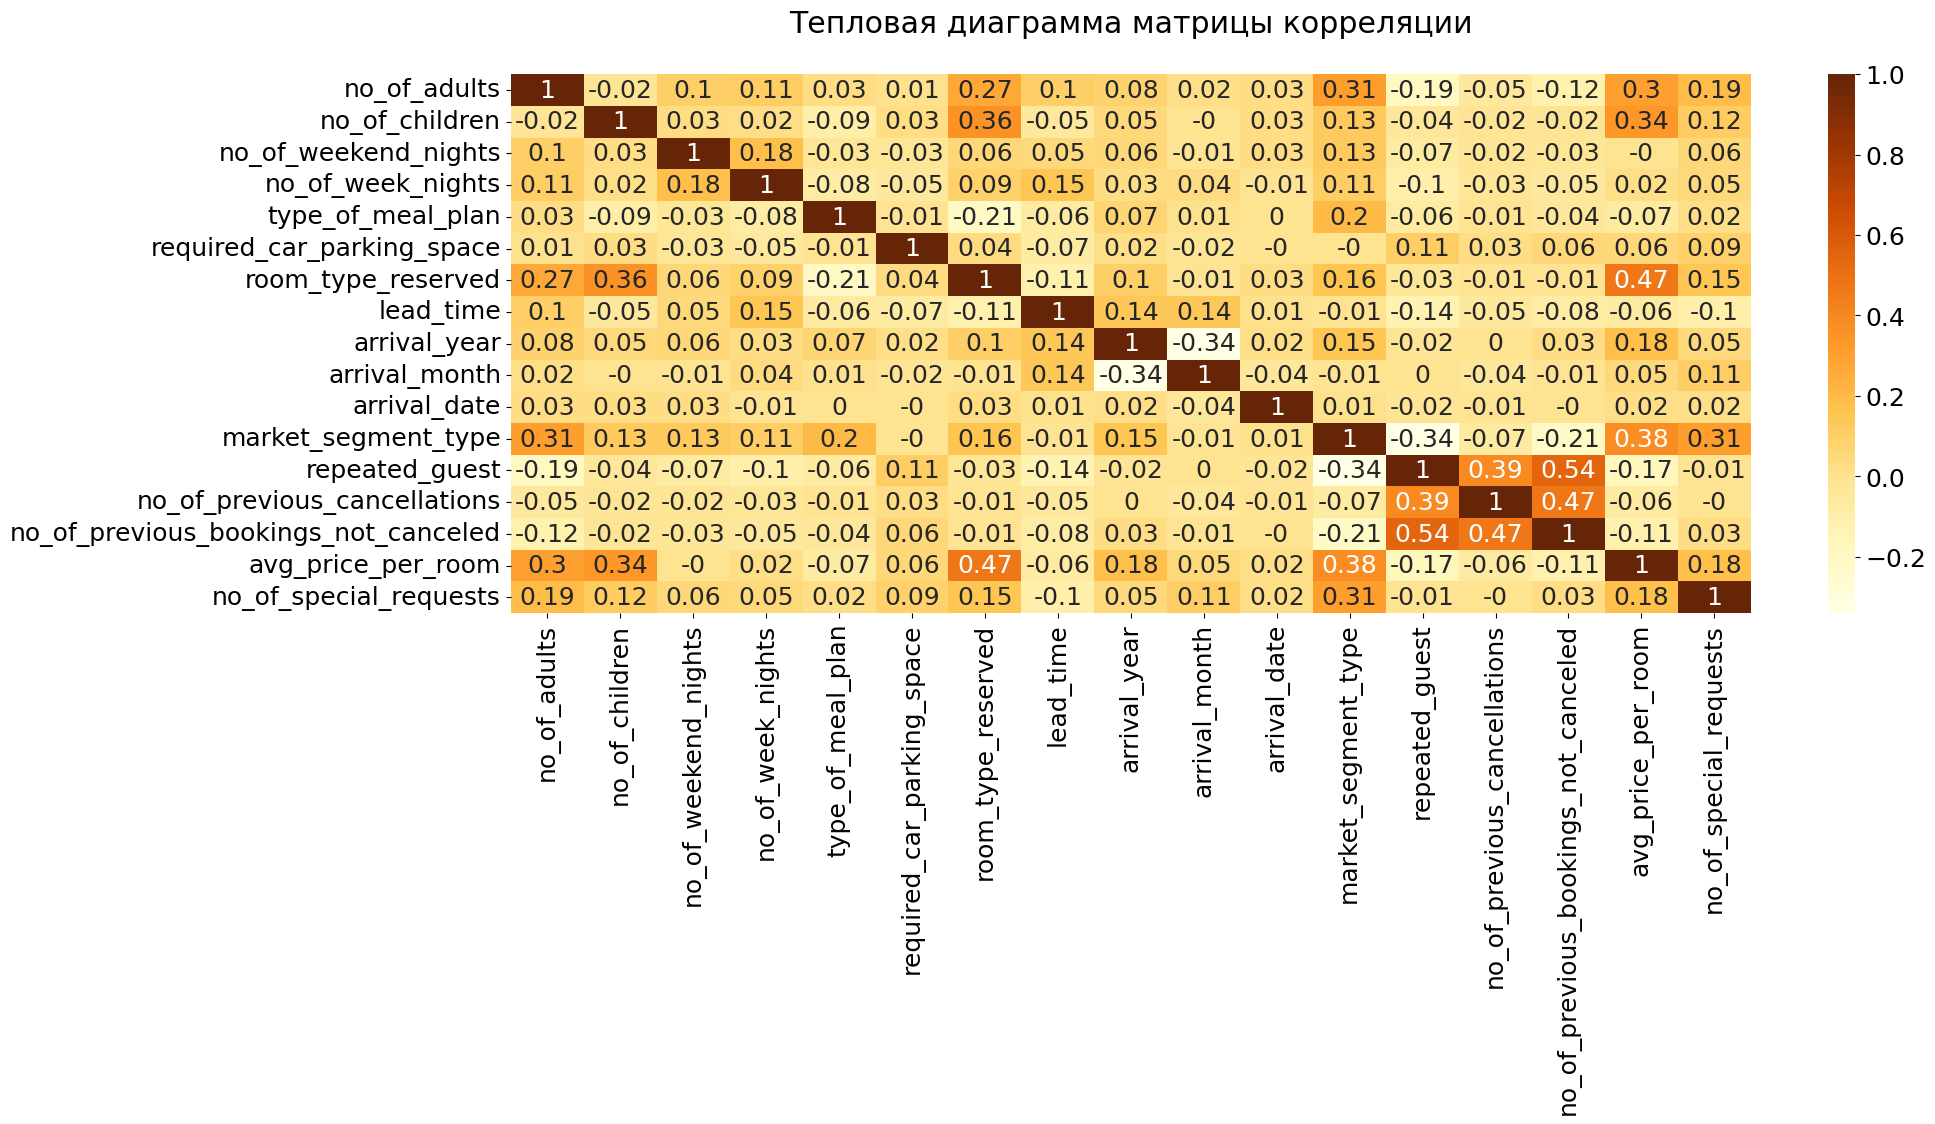

In [11]:
#Взглянем на матрицу корреляции
correlation = X.corr().round(2)
plt.figure(figsize = (20,7))
sns.heatmap(correlation, annot = True, cmap = 'YlOrBr')
plt.title("Тепловая диаграмма матрицы корреляции"+'\n');

Между фичами сильной корреляции не наблюдается.

In [12]:
#Разделем данные на обучающую, валидную и  тестовую выборки
X_train, X_test, y_train, y_test_ = train_test_split(X, y, test_size=0.3, random_state=5, stratify=y)

# **2. Построение модели машинного обучения**

### 2.1  Логистическая регрессия

In [13]:
# Масщтабируем функцию
scaler = StandardScaler()
scaler.fit(X_train)

X_train_tr = scaler.transform(X_train) 
X_test_tr = scaler.transform(X_test)


In [14]:
# Модель логистической регрессии с автоматической балансировкой классов 
model_LR = LogisticRegression(random_state = 5, 
                              solver = 'newton-cg', 
                              n_jobs = -1,
                              class_weight='balanced') \
                              .fit(X_train_tr, y_train)
predictions_LR = model_LR.predict(X_test_tr)

print("Accuracy:", accuracy_score(predictions_LR, y_test_))
print("F1:", f1_score(predictions_LR, y_test_))

Accuracy: 0.7705595883488009
F1: 0.6857142857142857


### 2.2  Метод KNN (ближайших соседей)

In [15]:
# Модель ближайших соседей
classifier = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
classifier.fit(X_train_tr, y_train)
predictions_knn = classifier.predict(X_test_tr)

print("Accuracy:", accuracy_score(predictions_knn, y_test_))
print("F1:", f1_score(predictions_knn, y_test_))

Accuracy: 0.8489387117522742
F1: 0.7639965546942291


### 2.3  Дерево решений

In [16]:
#Разделем данные на обучающую, валидную и  тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=5, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=5, stratify=y_val)

print(f"Количество строк в y_test по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_val по классам: {np.bincount(y_valid)}")
print(f"Количество строк в y_val по классам: {np.bincount(y_test)}")

Количество строк в y_test по классам: [14634  7131]
Количество строк в y_val по классам: [4878 2377]
Количество строк в y_val по классам: [4878 2377]


In [17]:
value_param = []
best_result = 0
best_depth = 0
for count_features in range(1,5):
    for depth in range(1, 5):
        model_DT = DecisionTreeClassifier(random_state=5, 
                                          max_depth = depth, 
                                          max_features=count_features) \
                                          .fit(X_train, y_train) 
        predictions_DT = model_DT.predict(X_valid)
        result = accuracy_score(y_valid, predictions_DT)
        value_param.append([result, depth, count_features])
        if result > best_result:
            best_result = result
            best_depth = depth
            best_features = count_features
            best_model_DT = model_DT
            

best_model_DT

DecisionTreeClassifier(max_depth=4, max_features=3, random_state=5)

In [18]:
#Имея лучшую модель дерева решений, соеденим валидную и тестовую выборку в общую. И обучим модель на ней.
X_common = pd.concat([X_train, X_valid])
y_common = pd.concat([y_train, y_valid])
best_model_DT.fit(X_common, y_common)
predictions_DT = best_model_DT.predict(X_test)

print("Accuracy на тестовой выборке:", accuracy_score(predictions_DT, y_test))
print("F1 на тестовой выборке:", f1_score(predictions_DT, y_test))

Accuracy на тестовой выборке: 0.7812543073742246
F1 на тестовой выборке: 0.6402176377238721


### 2.4  Случайный лес 

In [19]:
%%time
#Подберем гиперпараметры на валидной выборке
best_result_2 = 0 
best_result_1 = 0
for est in range(5, 51, 5):
    for depth in range(1, 25):
        for count_features in range(1,4):
            model_FC = RandomForestClassifier(random_state=5,
                                              n_estimators=est, 
                                              max_depth=depth, 
                                              max_features=count_features,
                                              n_jobs=-1) \
                                              .fit(X_train, y_train)
            predictions_FC = model_FC.predict(X_valid)
            result_1 = accuracy_score(y_valid, predictions_FC)
            result_2 = f1_score(y_valid, predictions_FC)
            if result_2 > best_result_2:
                best_result_1 = result_1
                best_result_2 = result_2
                best_model_FC = model_FC

print("Accuracy на валидной выборке:", best_result_1)
print("F1 на валидной выборке:", best_result_2)
best_model_FC

Accuracy на валидной выборке: 0.8975878704341833
F1 на валидной выборке: 0.8374535112666812
Wall time: 1min 30s


RandomForestClassifier(max_depth=20, max_features=3, n_estimators=45, n_jobs=-1,
                       random_state=5)

In [20]:
#Имея лучшую модель случайного леса, обучим ее на обшей выборке.
best_model_FC.fit(X_common, y_common)
predictions_FC = best_model_FC.predict(X_test)

print("Accuracy на тестовой выборке:", accuracy_score(predictions_FC, y_test))
print("F1 на тестовой выборке:", f1_score(predictions_FC, y_test))

Accuracy на тестовой выборке: 0.8968986905582357
F1 на тестовой выборке: 0.8363238512035011


### 2.5 Градиентный бустинг

In [21]:
%%time
#Настроим гиперпараметры
loss = ['deviance', 'exponential']
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 6, 8]
min_samples_split = [2, 4, 6, 10]
max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

model = GradientBoostingClassifier(random_state = 5)

random_cv = RandomizedSearchCV(estimator=model,
    param_distributions=hyperparameter_grid,
    cv=5, n_iter=25, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 1, 
    return_train_score = True,
    random_state=42)

random_cv.fit(X_common, y_common)

best_model_GB = random_cv.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Wall time: 8min 23s


In [22]:
predictions_GB = best_model_GB.predict(X_test)

print("Accuracy на тестовой выборке:", accuracy_score(predictions_GB, y_test))
print("F1 на тестовой выборке:", f1_score(predictions_GB, y_test))

Accuracy на тестовой выборке: 0.9029634734665748
F1 на тестовой выборке: 0.84688995215311


In [23]:
scale = {"accuracy":np.array([accuracy_score(predictions_LR, y_test_),
                              accuracy_score(predictions_DT, y_test), 
                              accuracy_score(predictions_knn, y_test_),
                              accuracy_score(predictions_FC, y_test),
                              accuracy_score(predictions_GB, y_test)]),
         "f1":np.array([f1_score(predictions_LR, y_test_), 
                        f1_score(predictions_DT, y_test),
                        f1_score(predictions_knn, y_test_), 
                        f1_score(predictions_FC, y_test),
                        f1_score(predictions_GB, y_test)])}
models = ['Логистическая регрессия', 
          'Дерево решений', 
          'Метод KNN (ближайших соседей)', 
          "Случайный лес", 
          'Градиентный бустинг']

TOP_5 = pd.DataFrame(scale, index=models)
TOP_5

,accuracy,f1
Логистическая регрессия,0.770560,0.685714
Дерево решений,0.781254,0.640218
Метод KNN (ближайших соседей),0.848939,0.763997
Случайный лес,0.896899,0.836324
Градиентный бустинг,0.902963,0.846890


# **3. Общий вывод**

В хоте предобработки данных был исключен столбец, который не несет никакой информации, также перекодированы столбцы с категориальными признаками. 
В данной работе было рассмотрено 5 моделей машинного обучения для задачи классификации. 
Для подбора гиперпараметров было сделано следующее:
 
 * для линейных моделей данные были масштабированы, была произведен баланс классов.
  * для моделей семейств деревьев были произведены подборы гиперпараметров, где-то по отложенной выборке, где-то кросс-валидацией.

Лучшей моделью себя показал **Градиентный бустинг**, хоть и ресурсов требует он не мало.  
**accuracy = 0.9**  
**f1 = 0.85**